In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [3]:
# Importing modules

from tqdm import tqdm
import pandas as pd

# Loading the bulk file

current_season = None
current_episode = None
current_scene = None

data = {
    "season": [],
    "episode": [],
    "scene": [],
    "character": [],
    "text": [],
}

with open("data/all_scripts.txt", encoding="utf-8") as f:
    for line in tqdm(f.readlines()):
        if line.startswith(">> "):
            current_season = line.split(" ")[2]
            current_episode = line.split(" ")[4]
        elif line.startswith("> "):
            current_scene = line.replace("> ", "").strip()
            if current_scene.endswith("."):
                current_scene = current_scene[:-1]
        else:
            character = line.split(": ")[0]
            text = ": ".join(line.split(": ")[1:]).strip()
            data["season"].append(current_season)
            data["episode"].append(current_episode)
            data["scene"].append(current_scene)
            data["character"].append(character)
            data["text"].append(text)

# Converting to dataframe

df = pd.DataFrame(data)

# Displaying

display(df)

# Counting the number of scenes

for season in df['season'].unique():
    df_copy = df.query('season == @season').drop_duplicates(subset=['episode', 'scene'], inplace=False).copy()
    print(f"In season {season}, there are {df_copy.shape[0]} scenes.")

  0%|          | 0/54329 [00:00<?, ?it/s]

100%|██████████| 54329/54329 [00:00<00:00, 993912.55it/s]


,season,episode,scene,character,text
0,01,01,A corridor at a sperm bank,Sheldon,So if a photon is directed through a plane wit...
1,01,01,A corridor at a sperm bank,Leonard,"Agreed, what’s your point?"
2,01,01,A corridor at a sperm bank,Sheldon,"There’s no point, I just think it’s a good ide..."
3,01,01,A corridor at a sperm bank,Leonard,Excuse me?
4,01,01,A corridor at a sperm bank,Receptionist,Hang on.
...,...,...,...,...,...
51287,10,24,Sheldon’s office,Ramona,"Mmm. No big deal, I enjoy spending time with you."
51288,10,24,Sheldon’s office,Sheldon,"And I with you. Question, are you seeking a ro..."
51289,10,24,Sheldon’s office,Ramona,What if I were?
51290,10,24,Sheldon’s office,Sheldon,"Well, that would raise a number of problems. W..."


In season 01, there are 156 scenes.
In season 02, there are 203 scenes.
In season 03, there are 190 scenes.
In season 04, there are 216 scenes.
In season 05, there are 198 scenes.
In season 06, there are 208 scenes.
In season 07, there are 203 scenes.
In season 08, there are 190 scenes.
In season 09, there are 176 scenes.
In season 10, there are 185 scenes.


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [4]:
# Add an extra column for easier analysis

df['id'] = 'S' + df['season'] + 'E' + df['episode']

# Get all characters appearing in >1 episode

recurrent_characters = (df
    .drop_duplicates(inplace=False, subset=['character', 'id'])
    .groupby('character')
    .count()
    .query('text > 1')
    .index
    .to_list()
)

print(f"There are {len(recurrent_characters)} recurrent characters:")
print(recurrent_characters)
print()

# Among these characters, get the ones with more than 90 dialog lines

chatty_recurrent_characters = (
    df
    .query('character in @recurrent_characters')
    .groupby('character')
    .count()
    .query('text > 90') # 'appearing more than 90 times'
    .index
    .to_list()
)

print(f"There are {len(chatty_recurrent_characters)} chatty recurrent characters:")
print(chatty_recurrent_characters)
print()

# Removing 'Man' from the list
chatty_recurrent_characters.remove('Man')
print(f"There are not {len(chatty_recurrent_characters)} chatty recurrent characters:")
print(chatty_recurrent_characters)


There are 84 recurrent characters:
['Adam', 'Alex', 'Alfred', 'All', 'Amy', 'Arthur', 'Assistant', 'Barman', 'Barry', 'Bernadette', 'Bert', 'Beverley', 'Beverly', 'Both', 'Claire', 'Col. Williams', 'Colonel Williams', 'Dan', 'Dave', 'Dimitri', 'Doctor', 'Emily', 'Everyone', 'Female Voice', 'Gablehauser', 'Gablehouser', 'Girl', 'Girls', 'Guy', 'Howard', 'Howard and Bernadette', 'Howard and Raj', 'Howard’s Mother', 'Ira', 'Janine', 'Katee Sackhoff', 'Kevin', 'Kripke', 'Kurt', 'LeVar', 'Leonard', 'Leonard and Howard', 'Lesley', 'Leslie', 'Lucy', 'Man', 'Man on TV', 'Mary', 'Mike', 'Mr Rostenkowski', 'Mr. Rostenkowski', 'Mrs Cooper', 'Mrs Davis', 'Mrs Hofstadter', 'Mrs Koothrappali', 'Mrs Wolowitz', 'Nurse', 'Penny', 'Penny’s Dad', 'Policeman', 'Priya', 'Raj', 'Ramona', 'Receptionist', 'Santa', 'Security Guard', 'Seibert', 'Sheldon', 'Siri', 'Spock', 'Steph', 'Stephen Hawking', 'Stuart', 'Summer', 'Together', 'Voice', 'Waiter', 'Waitress', 'Wil', 'Wil Wheaton', 'Woman', 'Woman on TV', 'Wya

## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [5]:
def replace_all(s: str, a: str, b: str) -> str:
    assert a not in b, "Infinite loop detected"
    while a in s:
        s = s.replace(a, b)
    return s

def replace_multiple(s: str, aa: list, b: str) -> str:
    for a in aa:
        s = replace_all(s, a, b)
    return s

df['text'] = df['text'].apply(lambda x: replace_multiple(x, EXCLUDE_CHARS, " ").lower())

**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [16]:
# Counting words

def unique(l: list) -> list:
    return list(set(l))

corpus = (" ".join(df['text'].to_list())).split(" ")
corpus_counts = {
    "word": [],
    "count": [],
}
for word in tqdm(unique(corpus)):
    corpus_counts["word"].append(word)
    corpus_counts["count"].append(corpus.count(word))

100%|██████████| 21692/21692 [01:50<00:00, 197.10it/s]


Text(0, 0.5, 'Frequency')

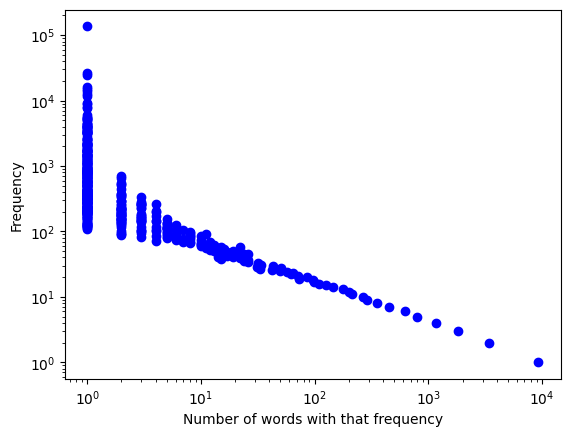

In [42]:
# Transforming the counts into a dataframe for easier computation later on

corpus_counts_df = pd.DataFrame(corpus_counts)

# Showing the histogram

number_of_words = corpus_counts_df.groupby('count').count()['word'].values
number_of_apparitions = corpus_counts_df.groupby('count').count().index.values

plt.loglog(number_of_words, number_of_apparitions, "bo")
plt.xlabel("Number of words with that frequency")
plt.ylabel("Frequency")

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [57]:
# Adding new column

df['num_of_words'] = df['text'].apply(lambda x: len(x.split(' ')))

df.groupby('character').agg({'num_of_words': 'sum'}).sort_values('num_of_words', ascending=False)

_ = """
The most chatty characters seem to be Sheldon and Leonard. How surprising!
"""

## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [65]:
df['season'] = df['season'].apply(lambda x: int(x))
df_train = df.query('season <= 8')
df_test = df.query('season > 8')

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [67]:
# ...

['so',
 'if',
 'a',
 'photon',
 'is',
 'directed',
 'through',
 'a',
 'plane',
 'with',
 'two',
 'slits',
 'in',
 'it',
 'and',
 'either',
 'slit',
 'is',
 'observed',
 'it',
 'will',
 'not',
 'go',
 'through',
 'both',
 'slits',
 '',
 'if',
 'it',
 's',
 'unobserved',
 'it',
 'will',
 '',
 'however',
 '',
 'if',
 'it',
 's',
 'observed',
 'after',
 'it',
 's',
 'left',
 'the',
 'plane',
 'but',
 'before',
 'it',
 'hits',
 'its',
 'target',
 '',
 'it',
 'will',
 'not',
 'have',
 'gone',
 'through',
 'both',
 'slits',
 '',
 'agreed',
 '',
 'what',
 's',
 'your',
 'point',
 '',
 'there',
 's',
 'no',
 'point',
 '',
 'i',
 'just',
 'think',
 'it',
 's',
 'a',
 'good',
 'idea',
 'for',
 'a',
 'tee',
 'shirt',
 '',
 'excuse',
 'me',
 '',
 'hang',
 'on',
 '',
 'one',
 'across',
 'is',
 'aegean',
 '',
 'eight',
 'down',
 'is',
 'nabakov',
 '',
 'twenty',
 'six',
 'across',
 'is',
 'mcm',
 '',
 'fourteen',
 'down',
 'is…',
 'move',
 'your',
 'finger…',
 'phylum',
 '',
 'which',
 'makes',
 'fou